In [6]:
from pathlib import Path
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Lightweight logging for notebooks
logging.basicConfig(level=logging.INFO, format="%(levelname)s: %(message)s")
sns.set_theme(style="whitegrid")

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import os
for dirname, _, filenames in os.walk('/content/sample_data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/content/sample_data/README.md
/content/sample_data/anscombe.json
/content/sample_data/Mall_Customers.csv
/content/sample_data/california_housing_test.csv
/content/sample_data/mnist_test.csv
/content/sample_data/mnist_train_small.csv
/content/sample_data/california_housing_train.csv


In [7]:
DATA_PATH = Path("/content/sample_data/Mall_Customers.csv")  # put CSV in the same folder as the notebook
N_CLUSTERS = 5

def load_data(path: Path) -> pd.DataFrame:
    """Load CSV into a DataFrame with basic validation.
    Raises FileNotFoundError if the file does not exist.
    """
    if not path.exists():
        raise FileNotFoundError(f"Dataset not found: {path}")
    df = pd.read_csv(path)
    logging.info("Loaded %d rows, %d columns", df.shape[0], df.shape[1])
    return df

# Load the data
try:
    customer_data = load_data(DATA_PATH)
except Exception as exc:
    logging.error("Failed to load data: %s", exc)
    raise

In [8]:
customer_data.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [9]:
customer_data.shape

(200, 5)

In [10]:
# dataframe info (dtypes and non-null counts)
customer_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [11]:
# checking for missing values
customer_data.isnull().sum()

,0
CustomerID,0
Gender,0
Age,0
Annual Income (k$),0
Spending Score (1-100),0


In [12]:
# select features by name (this will raise if columns are missing)
FEATURES = ["Annual Income (k$)", "Spending Score (1-100)"]
X = customer_data.loc[:, FEATURES].values
X.shape

(200, 2)

In [13]:
# preview the first 5 feature rows
X[:5]

array([[15, 39],
       [15, 81],
       [16,  6],
       [16, 77],
       [17, 40]])

In [17]:
# compute WCSS for K=1..10 on scaled features
def compute_wcss(X, max_k=10, random_state=42):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    wcss = []
    for k in range(1, max_k + 1):
        km = KMeans(n_clusters=k, init="k-means++", random_state=random_state, n_init=10)
        km.fit(X_scaled)
        wcss.append(km.inertia_)
    return wcss, scaler

wcss, _scaler = compute_wcss(X, max_k=10)
wcss

[399.99999999999994,
 269.69101219276405,
 157.70400815035939,
 108.92131661364358,
 65.56840815571681,
 55.057348270385965,
 44.86475569922555,
 37.22818767758587,
 32.39226763033118,
 29.981897788243703]

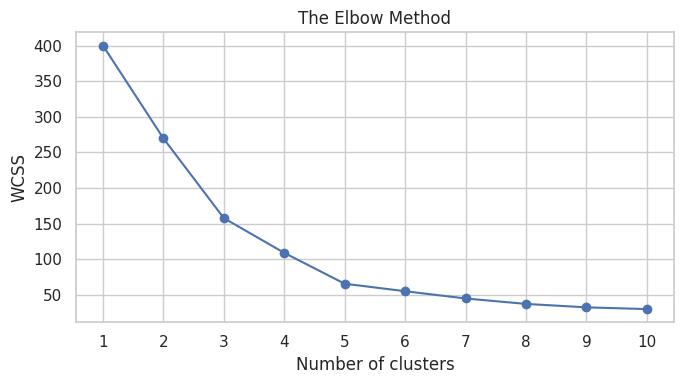

In [15]:
# plot an elbow graph
plt.figure(figsize=(7,4))
plt.plot(range(1,11), wcss, marker="o")
plt.title("The Elbow Method")
plt.xlabel("Number of clusters")
plt.ylabel("WCSS")
plt.xticks(range(1,11))
plt.tight_layout()
plt.show()

In [19]:
pipeline = make_pipeline(StandardScaler(), KMeans(n_clusters=N_CLUSTERS, init="k-means++", random_state=0, n_init=10))
# fit & predict
labels = pipeline.fit_predict(X)
# extract fitted steps
scaler = pipeline.named_steps['standardscaler']
kmeans = pipeline.named_steps['kmeans']
print("Trained KMeans with %d clusters", N_CLUSTERS)
labels[:10]  # preview the first 10 assigned labels

Trained KMeans with %d clusters 5


array([3, 4, 3, 4, 3, 4, 3, 4, 3, 4], dtype=int32)

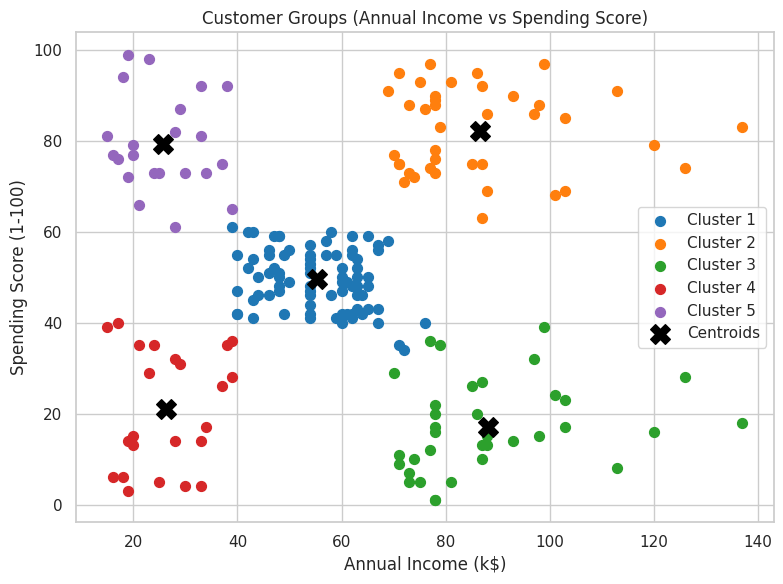

In [20]:
centroids_scaled = kmeans.cluster_centers_
centroids = scaler.inverse_transform(centroids_scaled)

# plotting clusters with readable colors and legend
plt.figure(figsize=(8,6))
palette = sns.color_palette("tab10", n_colors=N_CLUSTERS)
for i, color in enumerate(palette):
    plt.scatter(X[labels==i, 0], X[labels==i, 1], s=50, color=color, label=f"Cluster {i+1}")
# centroids
plt.scatter(centroids[:, 0], centroids[:, 1], s=200, c="black", marker="X", label="Centroids")
plt.title("Customer Groups (Annual Income vs Spending Score)")
plt.xlabel(FEATURES[0])
plt.ylabel(FEATURES[1])
plt.legend()
plt.tight_layout()
plt.show()